# Projekt: Erkennung von Spurmarkierungen
In diesem Projekt sollen Spurmarkierungen in zwei bestehenden Datensätzen erkannt werden: 
1. Udacity Nanodegree "Self-Driving Car Engineer" (https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd0013)
2. KITTI-Datensatz zur Erkennung von Spurmarkierungen (http://www.cvlibs.net/datasets/kitti/eval_road.php)

In [61]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
import os
import glob
import time

print('Willkommen beim Projekt "Erkennung von Spurmarkierungen"')

Willkommen beim Projekt "Erkennung von Spurmarkierungen"


### Global Parameters

In [62]:
# number of windows for sliding windows 
nwindows = 180

# value for last radius
last_r = None

# For radius calculation (pixels to meters)
y_m_per_pix = 30 / 720
x_m_per_pix = 3.7 / 1280

# Source and destination for perspective transformation
src = np.array([[598, 448], [684, 448], [1026, 668], [278, 668]], np.float32)
dst = np.array([[300, 0], [980, 0], [980, 720], [300, 720]], np.float32)

# Kernels for filter operations
kernel_small = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], 'uint8')
kernel_large = np.array([[0, 1, 1, 1, 0], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0]], 'uint8')

# ROI (trapezoid)
#ROI = np.array([[(570, 450),(650, 450),(1300, 650),(200, 650)]], dtype= np.int32)

### Basic functions for maipulation and plotting

In [63]:
# Warp image perspective
def warp(img, src=src, dst=dst):
    M = cv.getPerspectiveTransform(src, dst)
    return cv.warpPerspective(img, M, (img.shape[1], img.shape[0]))

# Crop image for region of interest
def crop(img, ROI):
    # Create blank img with same size as input img
    blank = np.zeros(img.shape[:2], np.uint8)

    # Fill region of interest
    region_of_interest = cv.fillPoly(blank, ROI, 255)

    # Create image of interest with region (resize)
    return cv.bitwise_and(img, img, mask=region_of_interest)

# Merge to masks
def merge(frame, img1, img2):
    both = frame.copy()
    both[np.where(np.logical_and(img1==0, img2==0))] = 0
    return both

# Overlay two images
def overlay(img, overlay):
    img[np.where(overlay!=0)] = [0,255,0]
    return img

# Overlay two images with alpha
def overlay_alpha(img, overlay):
    return cv.addWeighted(img, 1, overlay.astype(np.uint8), 0.5, 0.0)

# Show image inside defined plot
def show_img(plt, title, img, numCols, pos, cmap):
    plt.subplot(1, numCols, pos)
    plt.title(title)
    plt.imshow(img, cmap)

# Exercise 1: Camera calibration to equalize the images
The existing images are distorted due to lens and camera characteristics. Deskew the images using the OpenCV camera calibration routines (https://docs.opencv.org/4.5.3/dc/dbb/tutorial_py_calibration.html) and the recorded images.

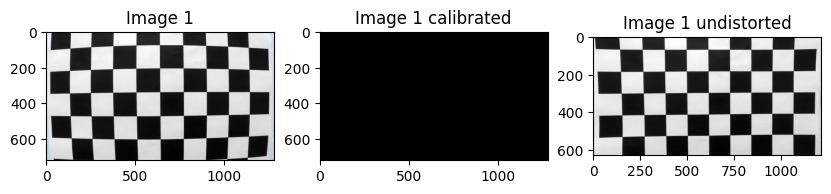

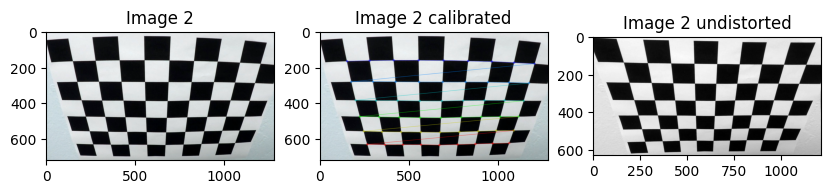

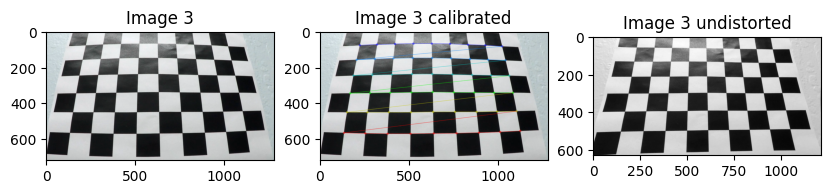

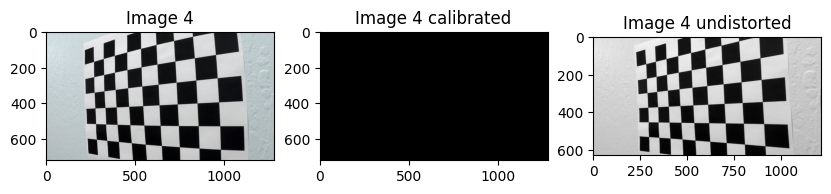

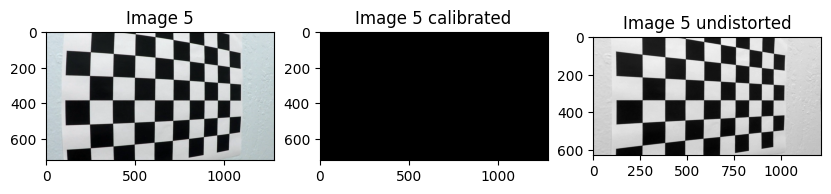

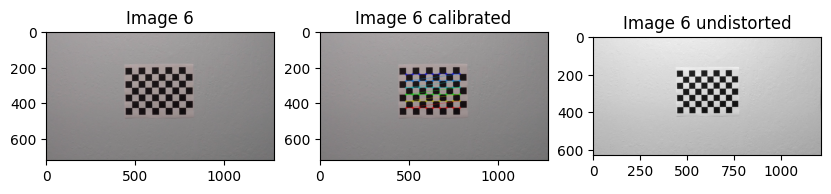

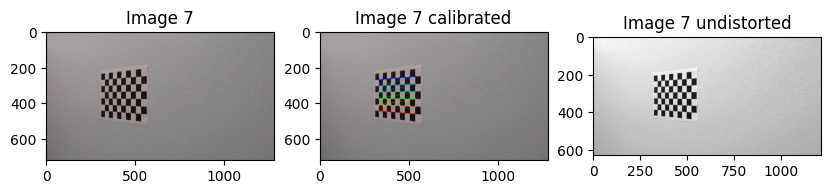

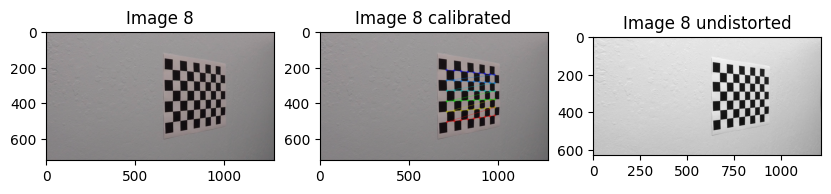

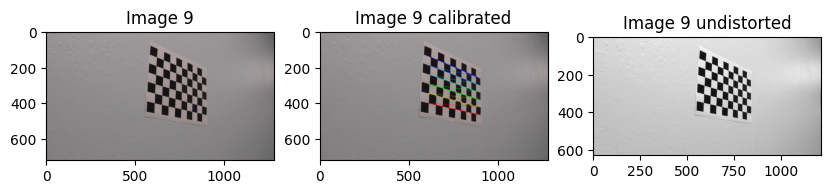

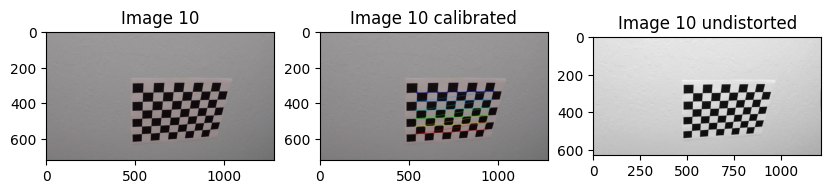

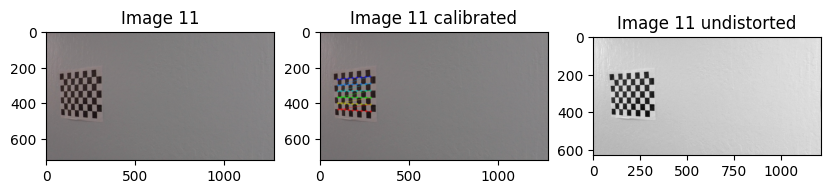

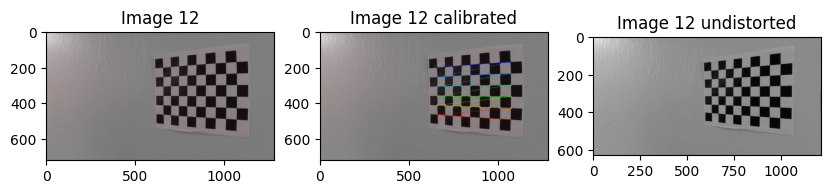

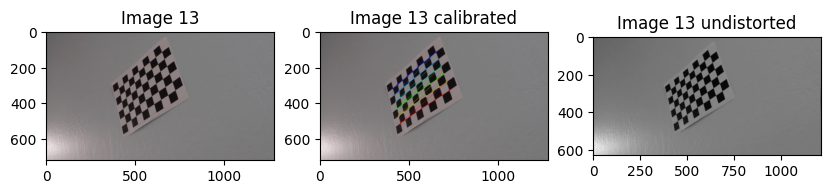

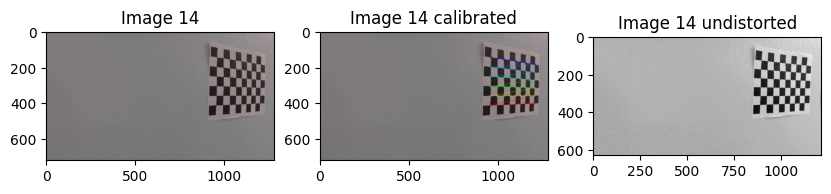

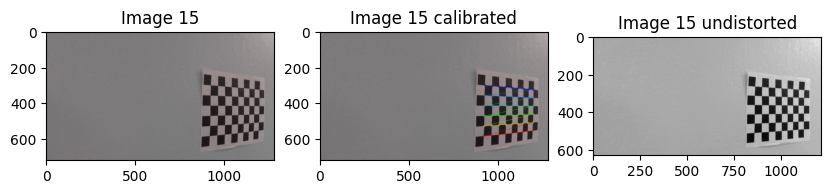

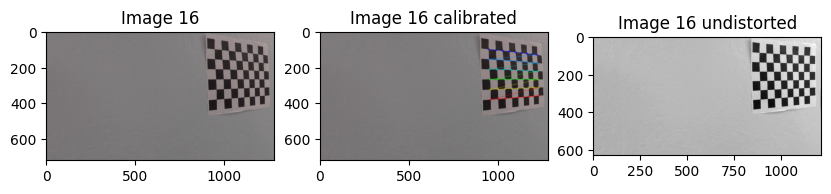

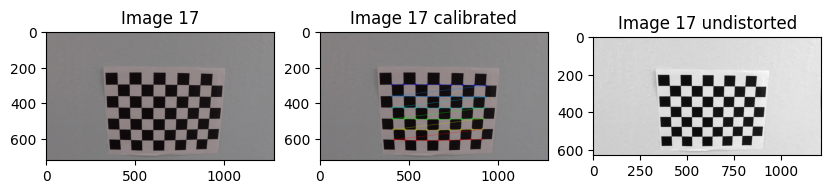

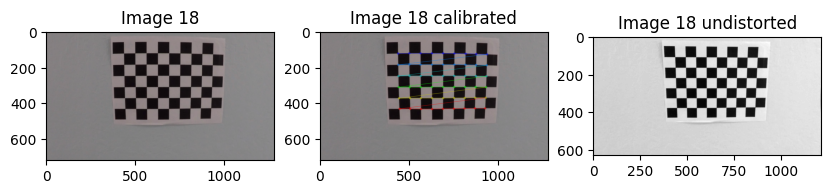

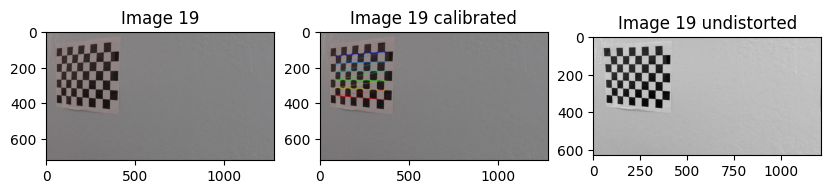

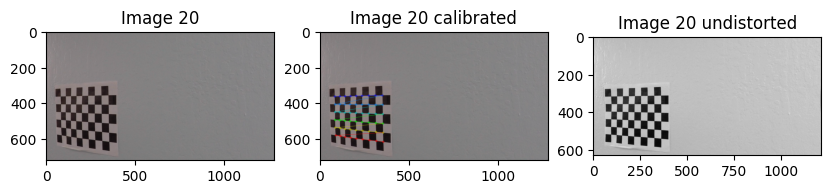

In [64]:
# Define columns and rows for chess board
width = 9
height = 6

# Arrays for obj and image points
objpoints = []
imgpoints = []

objp = np.zeros((width*height, 3), np.float32)
objp[:,:2] = np.mgrid[:width, :height].T.reshape(-1, 2)

# Calibrate image
def calibrate_image(x):
    # Read image and convert to gray
    image_path = './img/Udacity/calib/calibration' + str(x + 1) + '.jpg'
    img = cv.imread(image_path, -1)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find chess board corners
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    ret, corners = cv.findChessboardCorners(img, (width, height), None)
    
    # If corners are found add to obj array -> else return empty image
    if ret == True:
        # Add object points to array
        objpoints.append(objp)

        # Create corners and draw on image
        corners = cv.cornerSubPix(img_gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        drawn = cv.drawChessboardCorners(img, (width, height), corners, ret)
    else:
        drawn = np.zeros_like(img)
    return drawn

# Undistort image
def undistort_image(img):
    # Convert to gray and calibrate with found points
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, img_gray.shape[::-1], None, None)

    # Find new camera matrix and undistort with that matrix
    h, w = img_gray.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
    dst = cv.undistort(img_gray, mtx, dist, None, newcameramtx)

    # Crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    return dst

def show_chess_calibration():
    all_images = [None]*20

    # First: calibrate all images
    for x in range(20):
        all_images[x] = []
        all_images[x].append(calibrate_image(x))

    # Then: undistort all images
    for x in range(20):
        image_path = './img/Udacity/calib/calibration' + str(x + 1) + '.jpg'
        img = cv.imread(image_path, -1)
        all_images[x].append(undistort_image(img))

        # Show original, calibrated image and undistorted image
        plt.figure(figsize=(10,10))
        show_img(plt, 'Image ' + str(x + 1), img, 3, 1, 'gray')
        show_img(plt, 'Image ' + str(x + 1) + ' calibrated', all_images[x][0], 3, 2, None)
        show_img(plt, 'Image ' + str(x + 1) + ' undistorted', all_images[x][1], 3, 3, 'gray')
        plt.show()
show_chess_calibration()

In [65]:
# Reading a sample image
img1 = cv.cvtColor(cv.imread('./img/Udacity/calib/calibration1.jpg'), cv.COLOR_BGR2RGB)

# Calibration
# Initialize the calibration and calculate the parameters for the distortion correction of the image
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('./img/Udacity/calib/*.jpg')
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (7,6), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
h,  w = img1.shape[:2]
newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

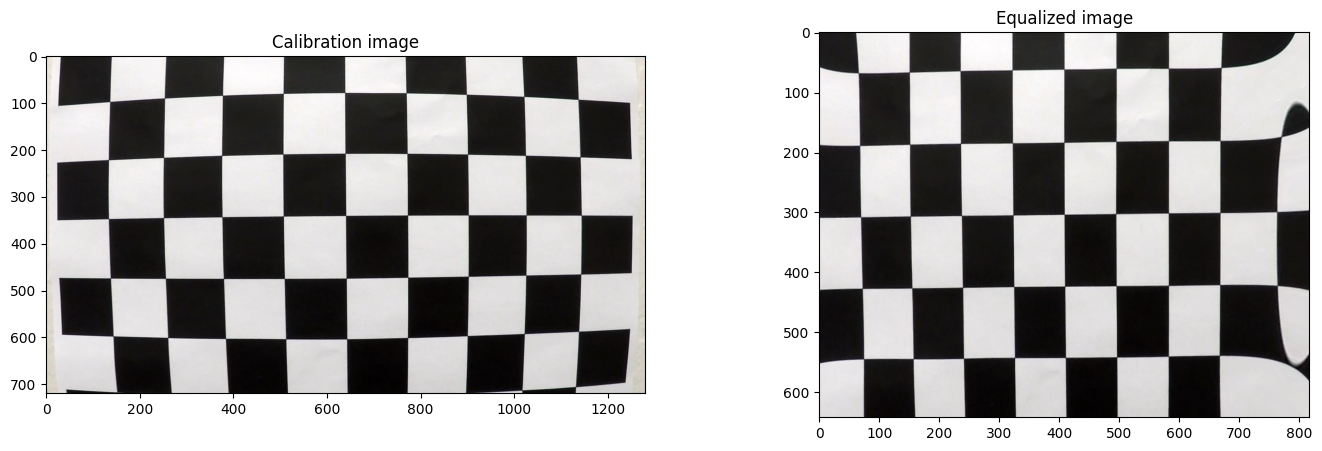

In [66]:
# Plot original image
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('Calibration image')

# Plot undistort image
dst = cv.undistort(img1, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
#cv.imwrite('calibresult.png', dst) # save image file
plt.subplot(1,2,2)
plt.imshow(dst)
plt.title('Equalized image')

plt.show()

# Exercise 2: Perspective transformation
Due to the camera perspective, the curvature of the found lane markings will not correspond to the real lane curvature. Therefore, transform the camera perspective images into a bird's eye view that corresponds to the real lane curvature.

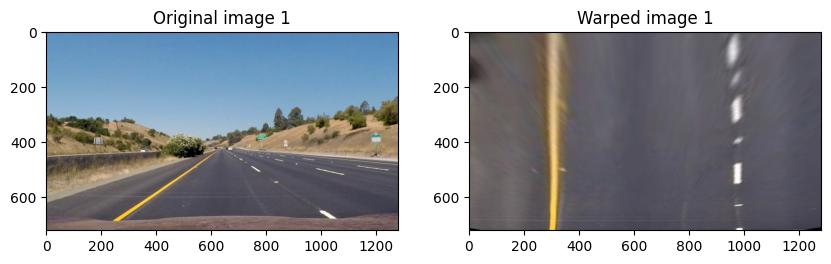

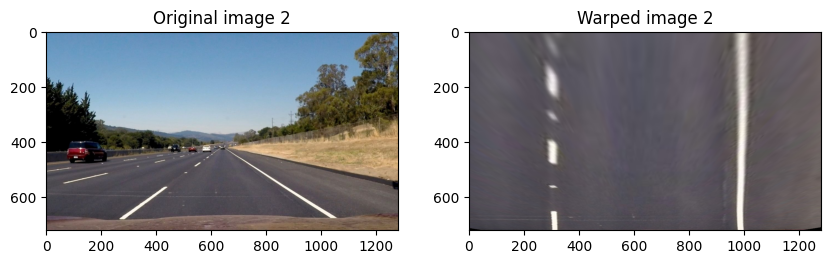

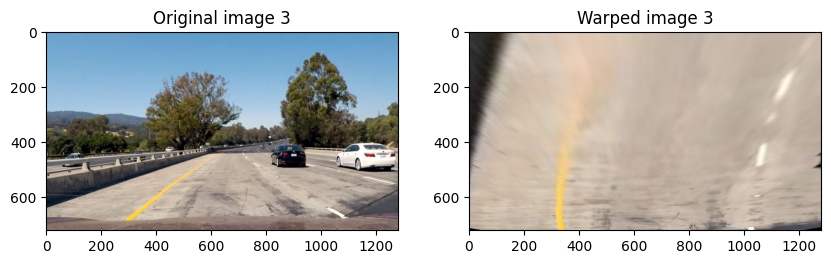

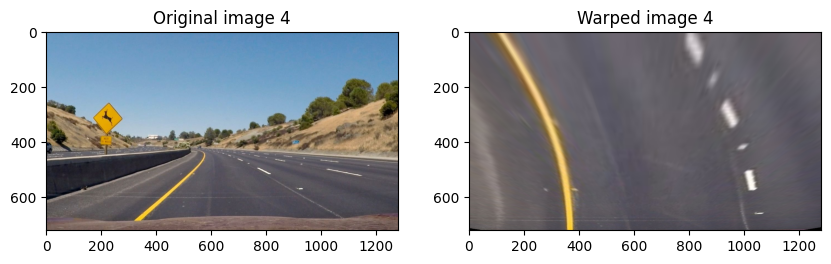

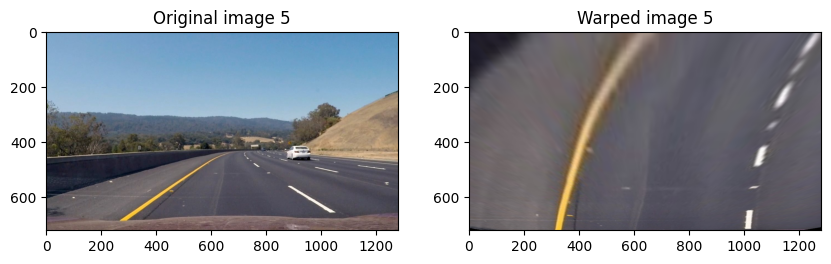

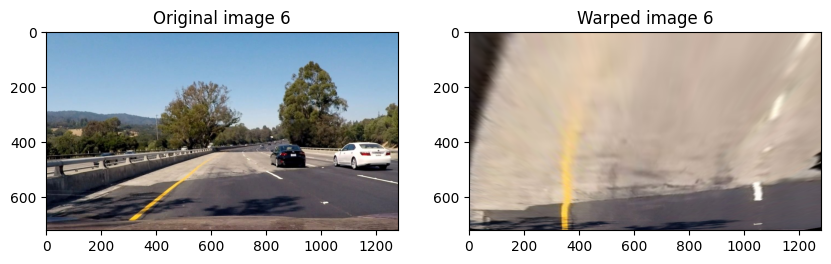

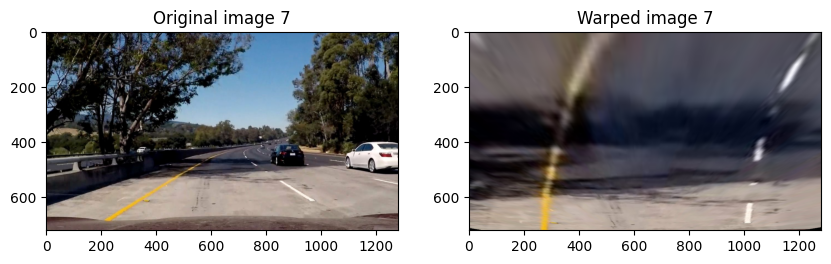

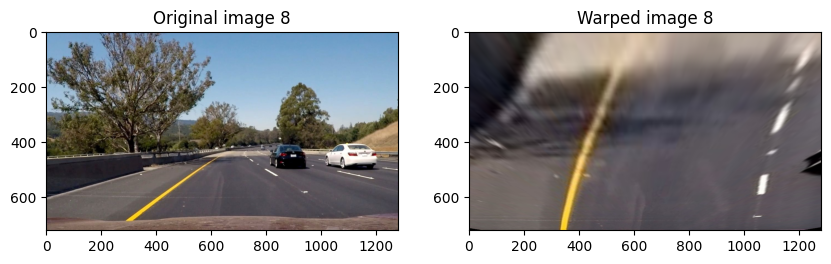

In [67]:
def image_segmentation():
    for x in range(8):    
        # Read image, convert to rgb and warp it
        img = cv.imread('./img/Udacity/image00' + str(x + 1) + '.jpg', -1)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img_warped = warp(img)

        # Show images
        plt.figure(figsize=(10,10))
        show_img(plt, 'Original image ' + str(x + 1), img, 2, 1, None)
        show_img(plt, 'Warped image ' + str(x + 1), img_warped, 2, 2, None)
        plt.show()
image_segmentation()

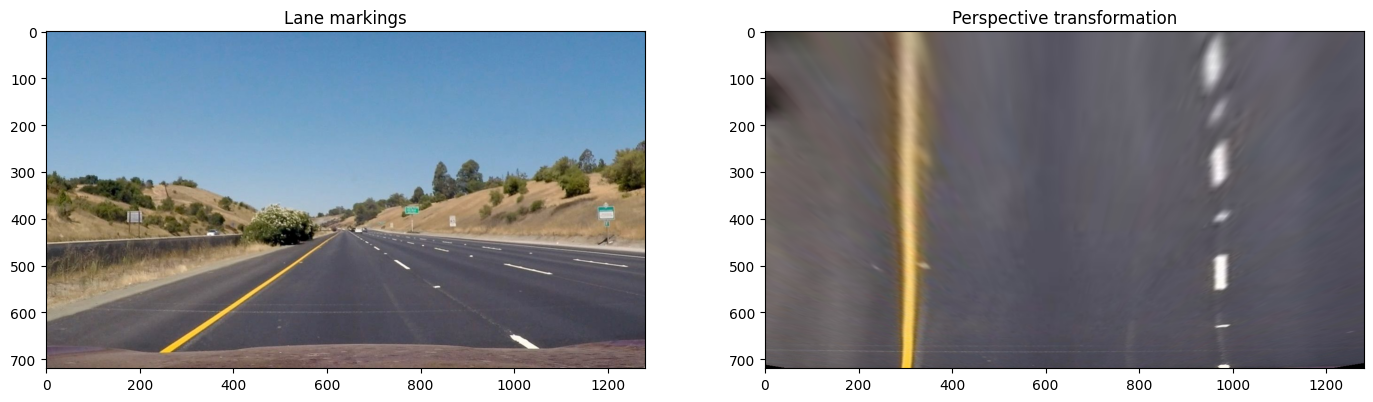

In [68]:
# einlesen eines Beispielbildes
img1 = cv.imread('./img/Udacity/image001.jpg', -1)
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
plt.title('Lane markings')

# definieren Sie die für eine Perspektivtransformation notwendigen Quell- und Zielpunkte [cools, rows]
src = np.float32([[598, 448], [684, 448], [1026, 668], [278, 668]])
dst = np.float32([[300, 0], [980, 0], [980, 720], [300, 720]])

M = cv.getPerspectiveTransform(src,dst)
img1_warp = cv.warpPerspective(img1,M,(img1.shape[1], img1.shape[0]))
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(img1_warp, cv.COLOR_BGR2RGB))
plt.title('Perspective transformation')
plt.show()

# Exercise 3: Recognition of lane markings
Recognize the lane markings or lanes on the image sources of Udacity. Apply the procedures known from the lecture. Feel free to use other procedures from other sources as well. The following objectives must be met on the final submission: 
- **Segmentation**: restrict the image to the area where the track markers are located.
- **Preprocessing**: perform camera calibration (for Udacity image sources) and perspective transformation.
- **Color spaces, histograms**: identify the track markers in the colors of the specified sources. Provided that other lane markers are found on the image, prioritize those lane markers that border your own lane
- **General**: Image processing must take place in real time --> Target: > 20 FPS.
- **General**: Accelerate processing by further measures Consider further measures (e.g. detection of lane marker in first frames, tracking of lane marker in further frames until lane marker positions change too much).
- **Minimal**: relevant track markers are detected continuously in the video "project_video" 
- **Additional**: relevant lane markers are detected in the video "challenge_video" and "harder_challenge_video" continuously
- **Additional**: relevant lane markers are applied to the KITTI dataset. What adjustments need to be made for your algorithm to transfer?
- **Additional**: Work out further measures to improve the speed of your algorithm.
- **Additional**: Detect objects in the image and visualize them (e.g. more vehicles, motorcycles, etc.). Please implement the object detection in such a way that it can be deactivated and does not pay into FPS calculation.

### Filters

In [69]:
# Convert image to yellow and white color space
def color_space(img):
    # Convert image to HSV
    img_hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    # Colorspace "yellow" in HSV: (15-40, 80-255, 160-255)
    mask_yellow = cv.inRange(img_hsv, (15, 80, 160), (40, 255, 255))
    # Colorspace "white" in HSV: (0-255, 0-20, 200-255)
    mask_white = cv.inRange(img_hsv, (0, 0, 200), (255, 20, 255))
    # Merge white and yellow masks
    masks = cv.bitwise_or(mask_yellow, mask_white)
    # Return image in gray
    return cv.cvtColor(cv.bitwise_and(img, img, mask=masks), cv.COLOR_BGR2GRAY)

# Apply canny filter to image
def canny_space(img, lower=80, upper=200):
    # Equalize histogramm with gray image
    equalized_gray_image = cv.equalizeHist(img)
    # Blur image three times
    equalized_gray_image = cv.GaussianBlur(equalized_gray_image, (5, 5), 0)
    equalized_gray_image = cv.GaussianBlur(equalized_gray_image, (5, 5), 0)
    equalized_gray_image = cv.GaussianBlur(equalized_gray_image, (5, 5), 0)
    # Return image with canny filter
    return cv.Canny(equalized_gray_image, lower, upper) 

# Dilate image (Expands the shapes of the image)
def dilate(img, iterations):
    return cv.dilate(img, kernel_small, iterations=iterations)

# Erode image (Reduces the shapes of the image)
def erode(img, iterations):
    return cv.erode(img, kernel_small, iterations=iterations)

# Close image (Removes noises)
def close(img, iterations):
    return cv.morphologyEx(img, cv.MORPH_CLOSE, kernel_large, iterations=iterations)

### Sliding Windows

In [70]:
def sliding_windows(warped_img, margin=200, minimum=30):
    # Histogram for image
    hist = np.sum(warped_img[warped_img.shape[0]//2:, :], axis=0)
        
    # Take peaks from left and right side of histogramm for starting points and add half margin
    mid = np.int(hist.shape[0] // 2)
    leftx_start = np.argmax(hist[:mid]) - margin // 2
    rightx_start = np.argmax(hist[mid:]) + mid + margin // 2

    # Window height based on number of windows
    window_height = np.int(warped_img.shape[0] // nwindows)
    
    # Calc points that are not zero in images
    nonzero = warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Initialize current positions for windows
    leftx_current = leftx_start
    rightx_current = rightx_start

    # Initialize values to be returned -> centers of windows
    lefts_good = np.empty(shape=(1,1), dtype=int)
    rights_good = np.empty(shape=(1,1), dtype=int)

    # Go through every window
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_img.shape[0] - (window + 1) * window_height
        win_y_high = warped_img.shape[0] - window*window_height
        
        # Calculate boundaries of the window
        win_xleft_low = leftx_current - margin  
        win_xleft_high = leftx_current + margin  
        win_xright_low =  rightx_current - margin 
        win_xright_high = rightx_current + margin  
        
        # Identify the pixels that are not zero within window
        left_inds = ((nonzeroy >= win_y_low ) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        right_inds = ((nonzeroy >= win_y_low ) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # If more than minimum pixels are found -> recenter next window
        if len(left_inds) > minimum:
            leftx_current = np.int(np.mean(nonzerox[left_inds]))
        if len(right_inds) > minimum:
            rightx_current = np.int(np.mean(nonzerox[right_inds]))

        # Add centers of windows to array
        lefts_good = np.append(lefts_good, leftx_current)
        rights_good = np.append(rights_good, rightx_current)
    return mid, lefts_good, rights_good


### Curve fitting and radius

In [71]:
# Calculate curves of lanes with polyfit function
def calc_curve(leftx, rightx, img):
    y = np.linspace(len(img), 0, nwindows+1).astype(int)
    left = np.polyfit(leftx, y, deg=2) 
    right = np.polyfit(rightx , y, deg=2)
    # Calculate radius for curves
    radius = calc_radius(left, right, leftx, rightx)
    return left, right, radius

# Calculate radius for two lines
def calc_radius(left_fit, right_fit, leftx, rightx):
    global last_r
    # Functions for curves by polyfit
    left_fitx = left_fit[0]*leftx**2 + left_fit[1]*leftx + left_fit[2]
    right_fitx = right_fit[0]*rightx**2 + right_fit[1]*rightx + right_fit[2]
    
    # Calculate functions again with meters for values
    left_fit_curve = np.polyfit(leftx*x_m_per_pix, left_fitx*y_m_per_pix, deg=2)
    right_fit_curve = np.polyfit(rightx*x_m_per_pix, right_fitx*y_m_per_pix, deg=2)
    
    # radius of curve
    left = cal_r(left_fit_curve, leftx)
    right = cal_r(right_fit_curve, rightx)

    # Take average from last radius and current radius (if last_r is not None)
    if (last_r != None):
        radius = round(np.mean([left, right, last_r]),0)
    else:
        radius = round(np.mean([left, right]),0)

    # Save current radius for next calculation
    last_r = round(np.mean([left, right]),0)
    return radius

# Calcurate curve radius | R_curve = ((1 + (2*w2*x + w1)^2)^3/2) / | 2*w2 |
def cal_r(street_area, x_range):
    # Take median from x values
    x = np.median(x_range * x_m_per_pix)

    # Calculation
    radius = ((1 + (2 * street_area[0] * x + street_area[1])**2)**(3/2)) / abs(2 * street_area[0])
    return radius

### Apply area

In [72]:
# Calculate points for lanes
def calc_lanes(street_area, midpoint, isleft):
    # Calculate extreme value for curve
    # DGL: ax^2 + bx + c -> 2ax + b = 0 -> x = (-b/2)/a
    x_extreme = (-street_area[1]) / 2 / street_area[0]

    # Set lower and upper boundaries
    if(isleft):
        lower = 50
        upper = midpoint
    else: 
        lower = midpoint
        upper = 1200
    
    diff_lower = abs(lower - x_extreme) # distance left to extreme point
    diff_upper = abs(upper - x_extreme) # distance right to extreme point
    
    
    # Define x values
    # if left is closer to extreme point -> set extreme point as lower boundary
    if (diff_lower < diff_upper):
        x = np.linspace(x_extreme, upper, 4500).reshape(-1, 1)
    # if right is closer to extreme point -> set extreme point as upper boundary
    else:
        x = np.linspace(lower, x_extreme, 4500).reshape(-1, 1)

    # Get y values from polyfit function
    y = (street_area[0] * (x**2) + street_area[1] * x + street_area[2]).reshape(-1, 1)

    # Merge points -> [[p1], [p2]...]
    xycoor = np.concatenate((x,y), axis=1)
    return xycoor

# Create area between lanes
def calc_area(img, left_points, right_points, with_alpha=False):
    # If with_alpha is True -> Make image colored
    if(with_alpha):
        zero_img = np.zeros((len(img), len(img[0]), 3))
    else:
        zero_img = np.zeros((len(img), len(img[0])))

    # sort by y values
    left_points = left_points.astype(np.int32)[np.argsort(left_points[:, 1])]
    right_points = right_points.astype(np.int32)[np.argsort(right_points[:, 1])][::-1]

    # Merge points -> [[p1], [p2]...]
    points = np.concatenate((left_points, right_points))

    # If with_alpha is True -> color image green, else color it white
    if(with_alpha):
        cv.fillPoly(zero_img, [points], color=[0,255,0])
    else:
        cv.fillPoly(zero_img, [points], color=255)
    return zero_img

### Bonus: Car detection

In [88]:
# Import haar features for car detection - credits to Kelbu (https://github.com/Kalebu/Real-time-Vehicle-Dection-Python)
cars_cascade = cv.CascadeClassifier('assets/haarcascade_car.xml')

# Detection of cars
def detect_cars(frame):
    cars = cars_cascade.detectMultiScale(frame, 1.15, 4)
    return cars

# Highlight cars -> Put rectangle and text around them
def highlight_cars(frame, cars):
    # Rectangle for every car that was found
    for (x, y, w, h) in cars:
        cv.rectangle(frame, (x, y), (x + w, y + h), color=(0, 255, 0), thickness=2)
        cv.putText(frame, "Car", (x + w // 2-20, y + h + 20), cv.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    return frame

### Render lane detection video

In [89]:
def render_lane_detection_video(video_file='project', object_detection=False, src=src, dst=dst):
  # Open video file
  cap = cv.VideoCapture('./img/Udacity/' + video_file + '_video.mp4')


  # If challenge video is played -> Define different points for transformation 
  CHALLENGE = (video_file == 'challenge') 
  if(CHALLENGE):
    src = np.array([[600, 480], [760, 480], [1026, 700], [278, 700]], np.float32)
    dst = np.array([[300, 0], [980, 0], [980, 720], [300, 720]], np.float32)

  # Check if camera opened successfully
  if (cap.isOpened() == False):
    print("Error opening video stream or file")

  # Start timer for fps counter
  start_timer = time.time() - 0.01
  frame_count = -1

  # Read every frame
  while(cap.isOpened()):
    ret, frame = cap.read()

    # Check if there is another frame
    if (frame is None):
      break
    orig = frame.copy()

    # Calculate Frame rate
    frame_count += 1
    ellapsed_time = time.time() - start_timer
    frame_rate = frame_count / ellapsed_time  

    # Calculate curve area only every fifth frame for performance reasons
    if (frame_count % 5 == 0):
      # Detect cars if car detection is on
      if (object_detection):
        cars = detect_cars(frame)

      # Step 1: Warp image
      frame = warp(frame, src, dst)

      # Step 2: Apply color mask and close image for get rid of small distrubances
      color = color_space(frame)
      color = close(color, 10)

      # For challenge video: dilate and crop color mask
      if(CHALLENGE):
        color = dilate(color, 10)
        ROI = np.array([[(525, 360), (1150, 340), (1150, 720), (900, 720) , (700, 550), (350, 720), (115, 720)]], dtype=np.int32) 
        color = crop(color, ROI) 

      # Step 3: Sliding windows to get curve points    
      midpoint, lefts, rights = sliding_windows(color)

      # Step 4: Calculate curve and radius
      left_fit, right_fit, radius = calc_curve(lefts, rights, orig)

      # Step 5: Fill area and transform area back
      AOI = calc_area(frame, calc_lanes(left_fit, midpoint, True), calc_lanes(right_fit, midpoint, False), False)
      AOI = warp(AOI, dst, src)

    # Overlay street area on every image
    frame = overlay(orig, AOI)

    # If car detection is on: Draw rectangles around cars
    if (object_detection):
      frame = highlight_cars(frame, cars)

    if ret == True:      
      # Add frame rate to video
      cv.putText(frame, "FPS: "+ str(round(frame_rate)), (0, 25), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv.LINE_AA)

      # Show curve radius (not for challenge video)
      if(not CHALLENGE):
        cv.putText(frame, "Curve radius: " + str(round(radius)).replace(".0", "") + "m", (len(frame[0])//2-150, 25), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 255), 2, cv.LINE_AA)
      cv.imshow('Frame', frame)

      # Close video with letter 'q'
      if cv.waitKey(25) & 0xFF == ord('q'):
        break
    else: 
      break

  # When everything done, release the video capture object
  cap.release()
  cv.destroyAllWindows()

### Play real time lane detection video (Project video)

Iterate through every frame from video:
- Calculate frame rate
- Calculate steps for lane detection only every fifth frame (for performance reasons):
    1. Perform perspective transform on image
    2. Apply color mask to detect yellow and white lanes and close image to reduce noise
    3. Apply sliding windows to find points for curve
    4. Calculate curve and radius
    5. Fill area and transform area image back
- Overlap area imgage on every frame to original
- Show curve radius and fps count

In [93]:
render_lane_detection_video(video_file='project', object_detection=False, src=src, dst=dst)

C:\Users\Jonathan\AppData\Local\Temp\ipykernel_7416\1482233567.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mid = np.int(hist.shape[0] // 2)
C:\Users\Jonathan\AppData\Local\Temp\ipykernel_7416\1482233567.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release no

# Exercise 4: Challenge video (Bonus task 1)


In [76]:
render_lane_detection_video(video_file='challenge', object_detection=False, src=src, dst=dst)

# Exercise 5: Object detection (Bonus task 2)

### Play project video with car detection

In [92]:
render_lane_detection_video(video_file='project', object_detection=True, src=src, dst=dst)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'


# Exercise 6: Port to Java app for Android smartphones (App)
A separate GitHub repo has been created for the app, which can be accessed via this [link](https://github.com/JoDi-2903/Road-Lane-Detection).